### Phase Time series

- This notebook is used to display mannuall-selected phase time series. 
- We will interpolate the time series and consider the frequency content.
- Brunt–Väisälä frequency
$$N = \sqrt{\frac{g}{\rho} \left( \frac{\partial\rho}{\partial z} \right)}$$

In [1]:
# Import necessary dependencies
import h5py, scipy, datetime, csv, sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from scipy import stats
from scipy.interpolate import CubicSpline
sys.path.append("../utils/")
import DASfuncs
from Data_processsing import *

#### 1. Prepare dataset

In [2]:
# data directory
rough_path = os.path.join('..', 'data', 'phase_time_series_lower_rough')
smooth_path = os.path.join('..', 'data', 'phase_time_series_lower_smooth')

In [3]:
# list files in increaseing sorted order
sorted_rough = sort_file(rough_path) 
sorted_smooth = sort_file(smooth_path)

In [4]:
# concatenate all sorted files
concat_rough_df = data_concat(sorted_rough, rough_path)
concat_smooth_df = data_concat(sorted_smooth, smooth_path)

In [5]:
concat_smooth_df

,optical distance along cable (m)
datetime,
2023-08-10 02:04:13,3021.716246
2023-08-10 02:11:09,3035.167890
2023-08-10 02:25:00,3014.656519
2023-08-10 02:30:06,3032.305838
2023-08-10 03:05:33,3018.951028
...,...
2023-08-17 23:35:26,2964.744746
2023-08-17 23:39:57,2989.042119
2023-08-17 23:43:50,2989.660597


In [6]:
prep_rough = prep_data(concat_rough_df)
prep_smooth = prep_data(concat_smooth_df)

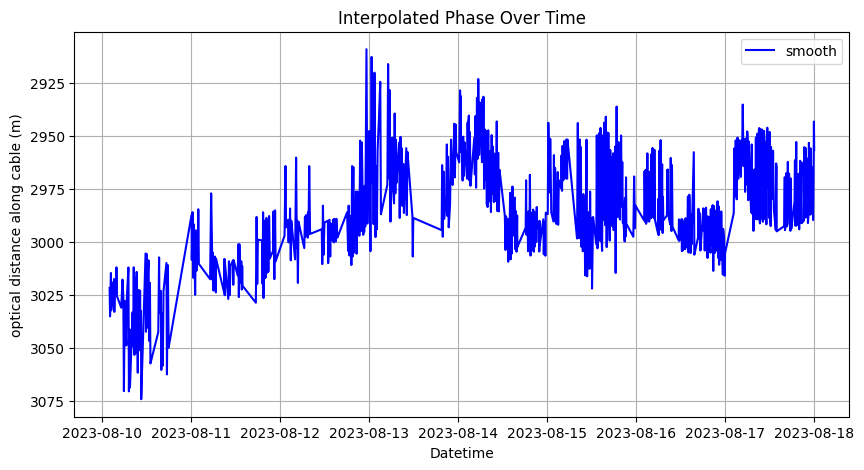

In [7]:
# Display the phase time series 
plt.figure(figsize=(10, 5))
# plt.plot(prep_rough.index, prep_rough['optical distance along cable (m)'], label='rough', color='green')
plt.plot(prep_smooth.index, prep_smooth['optical distance along cable (m)'], label='smooth', color='blue')
plt.xlabel('Datetime')
plt.ylabel('optical distance along cable (m)')
plt.gca().invert_yaxis()
plt.title('Interpolated Phase Over Time')
plt.legend()
plt.grid()
plt.show()

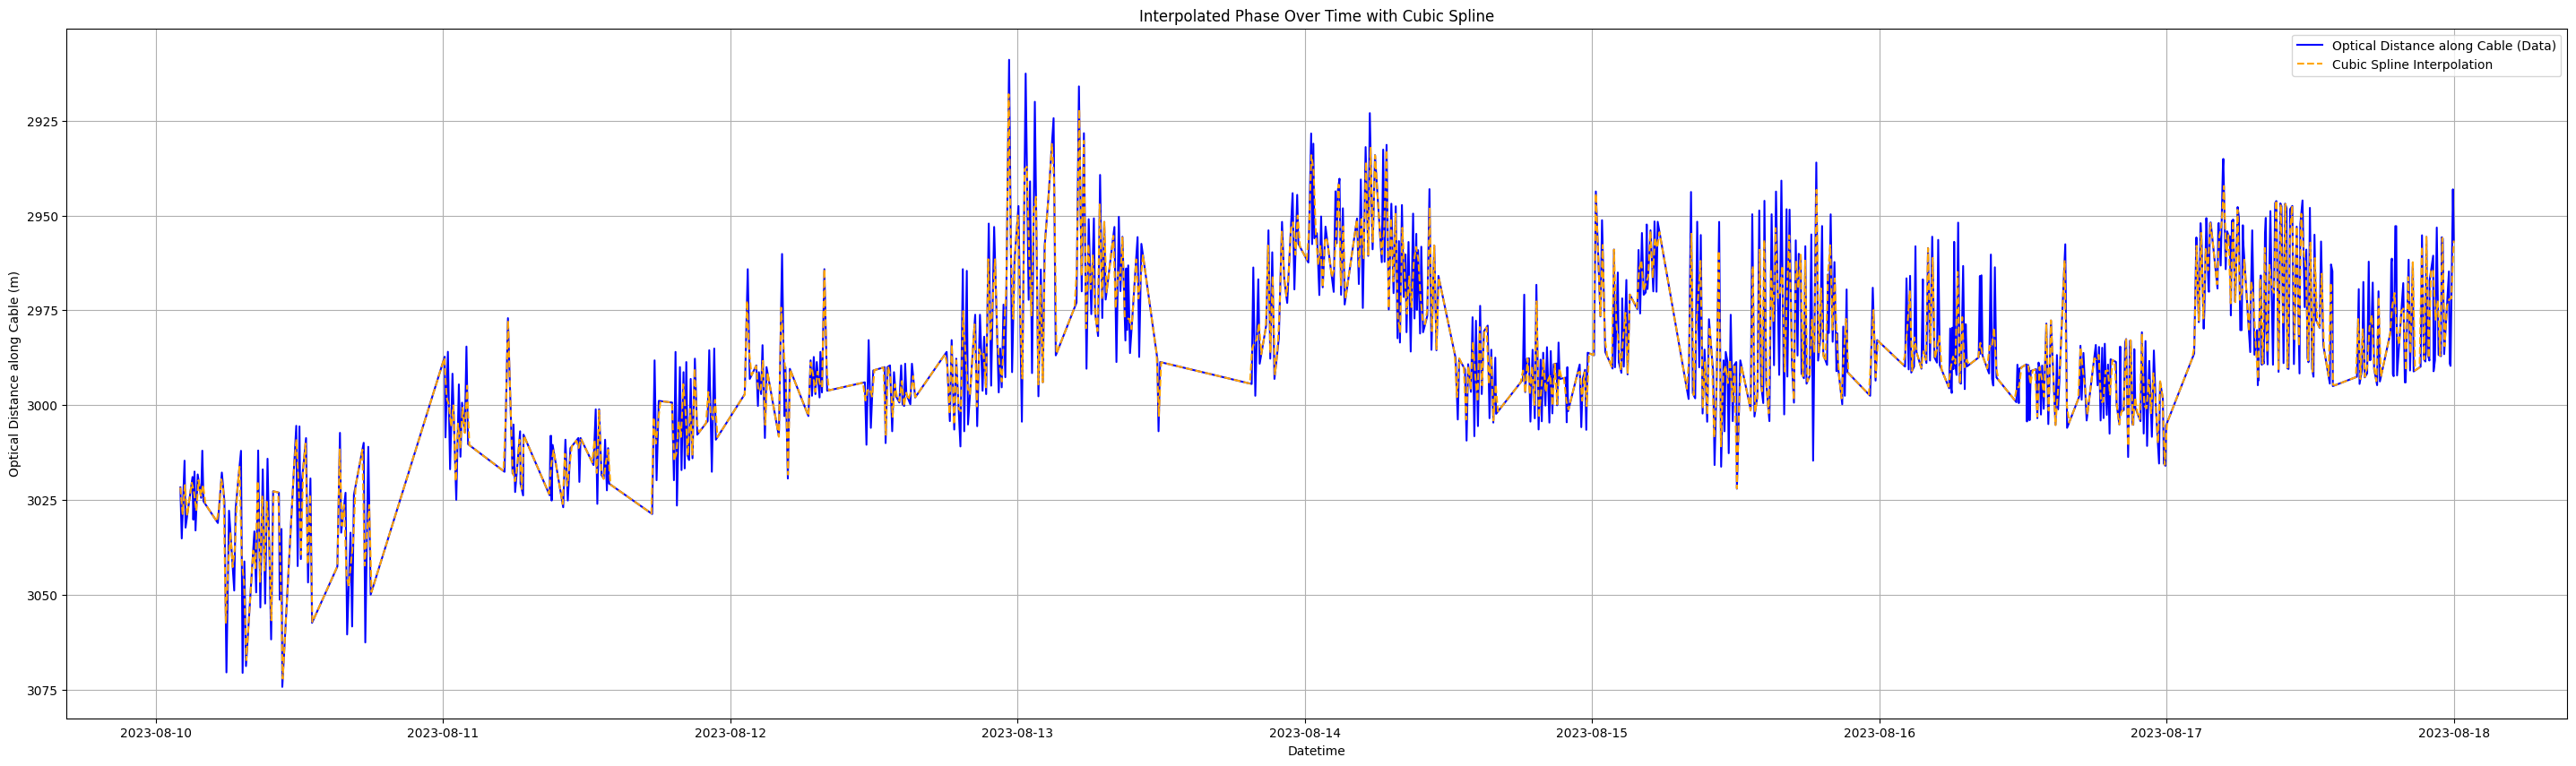

In [8]:
# Convert datetime index to numerical format for cubic spline
time_numeric = mdates.date2num(prep_smooth.index)  # Convert datetime index to float 
optical_distance = prep_smooth['optical distance along cable (m)']

# Create the cubic spline interpolation
cubic_spline = CubicSpline(time_numeric, optical_distance)

# Generate a dense range of times for smooth plotting
time_dense = np.linspace(time_numeric.min(), time_numeric.max(), 1000)
optical_distance_spline = cubic_spline(time_dense)

# Plot original data and the cubic spline interpolation
plt.figure(figsize=(36, 10))
plt.plot(prep_smooth.index, optical_distance, label='Optical Distance along Cable (Data)', color='blue')
plt.plot(mdates.num2date(time_dense), optical_distance_spline, label='Cubic Spline Interpolation', color='orange', linestyle='--')

plt.xlabel('Datetime')
plt.ylabel('Optical Distance along Cable (m)')
plt.gca().invert_yaxis()
plt.title('Interpolated Phase Over Time with Cubic Spline')
plt.legend()
plt.grid()
plt.show()


#### 2. Calculate spectrogram

/var/folders/pf/3_nyp_6j7059y5qxp6tr1_vm0000gn/T/ipykernel_68294/142889538.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left')


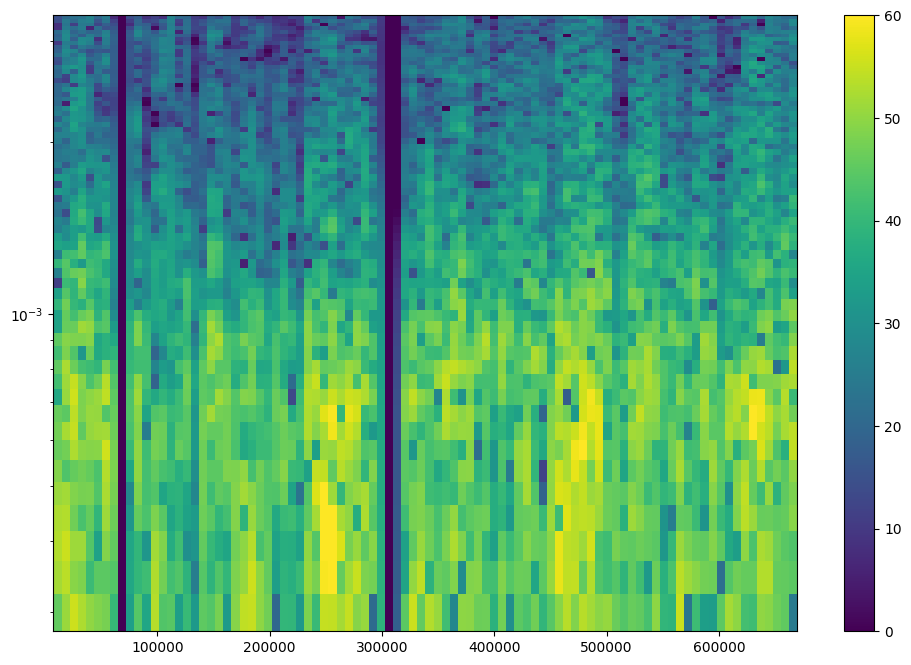

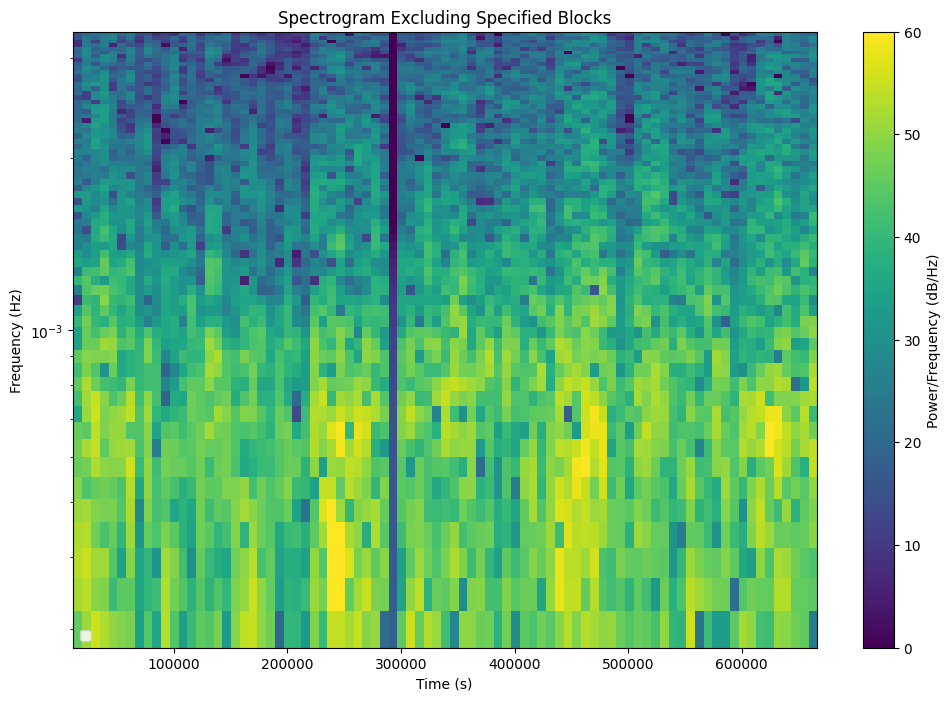

In [9]:
plt.figure(figsize=(12, 8))
Pxx, freqs, bins, im = plt.specgram(prep_smooth['optical distance along cable (m)'],
                                   NFFT=180*2, Fs=1/60, noverlap=120*2, detrend='linear',
                                   vmin=0, vmax=60)
plt.yscale('log')
plt.colorbar(im)
plt.ylim(1/3600, 1/300) # 5 min - 1 hr

# Exclude specified blocks (time bins)
# exclude_blocks = [7, 8, 30, 36, 40, 41, 42] # for rough
exclude_blocks = [7, 8, 14, 17, 40, 41, 41, 60] # for smooth
Pxx_filtered = np.delete(Pxx, exclude_blocks, axis=1)
bins_filtered = np.delete(bins, exclude_blocks)  # Filter corresponding time bins

# Plot filtered spectrogram
plt.figure(figsize=(12, 8))
plt.imshow(10 * np.log10(Pxx_filtered), aspect='auto', extent=[bins_filtered[0], bins_filtered[-1], freqs[0], freqs[-1]],
           origin='lower', vmin=0, vmax=60)
plt.yscale('log')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram Excluding Specified Blocks')
plt.ylim(1/3600, 1/300)
plt.legend(loc='lower left')
plt.show()


#### 3. Calculate corner frequencies

In [10]:
epsilon_freq = 1e-10  # A small constant to avoid zero frequency
freqs[0] = epsilon_freq

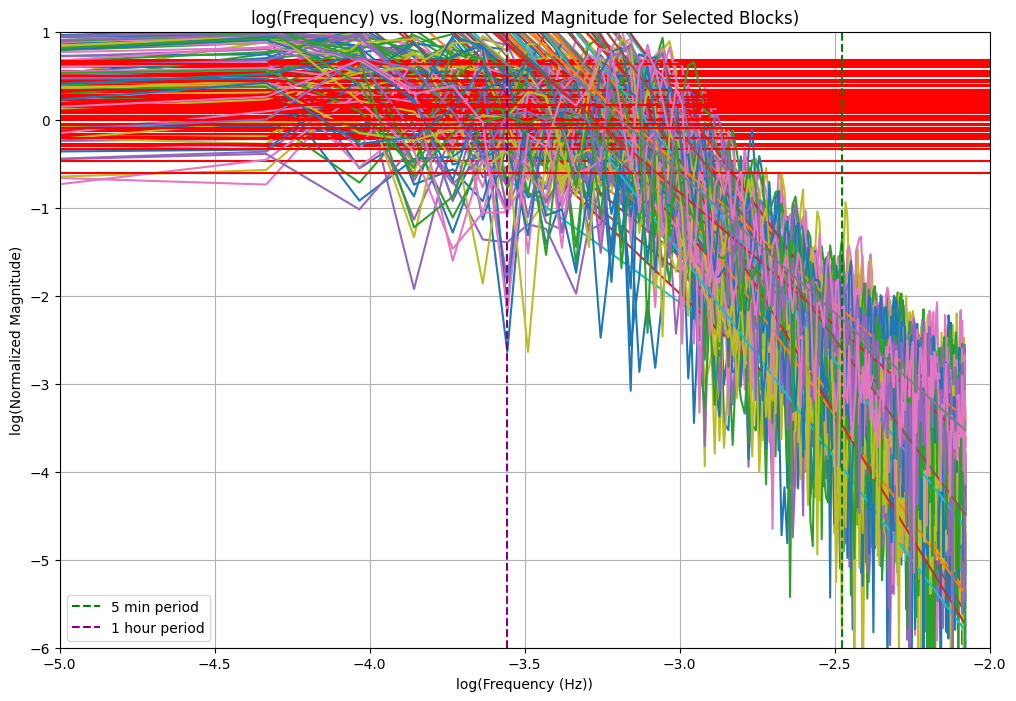

In [11]:
# Remove some weird signals 
# exclude_blocks = [7, 8, 30, 36, 40, 41, 42] # for rough
exclude_blocks = [7, 8, 14, 17, 40, 41, 42, 60] # for smooth
# Create empty lists storing corner frequencies
log_freq = []

# Define the frequency range mask
f_min_1 = 1e-5          # Lower bound: 10^-5 Hz
f_max_1 = 1/3600         # Upper bound: frequency corresponding to 1 hour (1/3600 Hz)
freqs_mask_1 = (freqs >= f_min_1) & (freqs <= f_max_1)


f_min_2 = 1e-3          # Lower bound: 10^-3 Hz
f_max_2 = 1/300         # Upper bound: frequency corresponding to 5 minutes (1/300 Hz)
freqs_mask_2 = (freqs >= f_min_2) & (freqs <= f_max_2)

# Plot only the masked frequencies for each block, excluding specified blocks
plt.figure(figsize=(12, 8))
for i in range(Pxx.shape[1])[:]:
    if i not in exclude_blocks:
    
        plt.plot(np.log10(freqs), np.log10(Pxx[:, i] / np.std(Pxx[:, i])))

        mean_1 = np.mean(np.log10(Pxx[freqs_mask_1, i] / np.std(Pxx[:, i])))
        plt.axhline(y=mean_1, color='red', linestyle='-')

        slope_2, intercept_2, *_ = stats.linregress(np.log10(freqs[freqs_mask_2]), np.log10(Pxx[freqs_mask_2, i] / np.std(Pxx[:, i])))
        plt.plot(np.log10(freqs), slope_2 * np.log10(freqs) + intercept_2, '-')

        log_freq_corner = (mean_1 - intercept_2) / slope_2
        log_freq.append(log_freq_corner)

plt.xlabel('log(Frequency (Hz))')
plt.ylabel('log(Normalized Magnitude)')
plt.title('log(Frequency) vs. log(Normalized Magnitude for Selected Blocks)')

# Draw vertical lines at frequencies for 5 minutes and 1 hour

plt.axvline(x=np.log10(1/300), color='green', linestyle='--', label="5 min period")
plt.axvline(x=np.log10(1/3600), color='purple', linestyle='--', label="1 hour period")

plt.xlim(-5, -2)
plt.ylim(-6, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

In [12]:
log_freq_ = log_freq.copy()

In [13]:
log_freq_.insert(7, float('nan'))
log_freq_.insert(8, float('nan'))
log_freq_.insert(14, float('nan'))
log_freq_.insert(17, float('nan'))
log_freq_.insert(40, float('nan'))
log_freq_.insert(41, float('nan'))
log_freq_.insert(42, float('nan'))
log_freq_.insert(60, float('nan'))

#### 4. N(t) time series

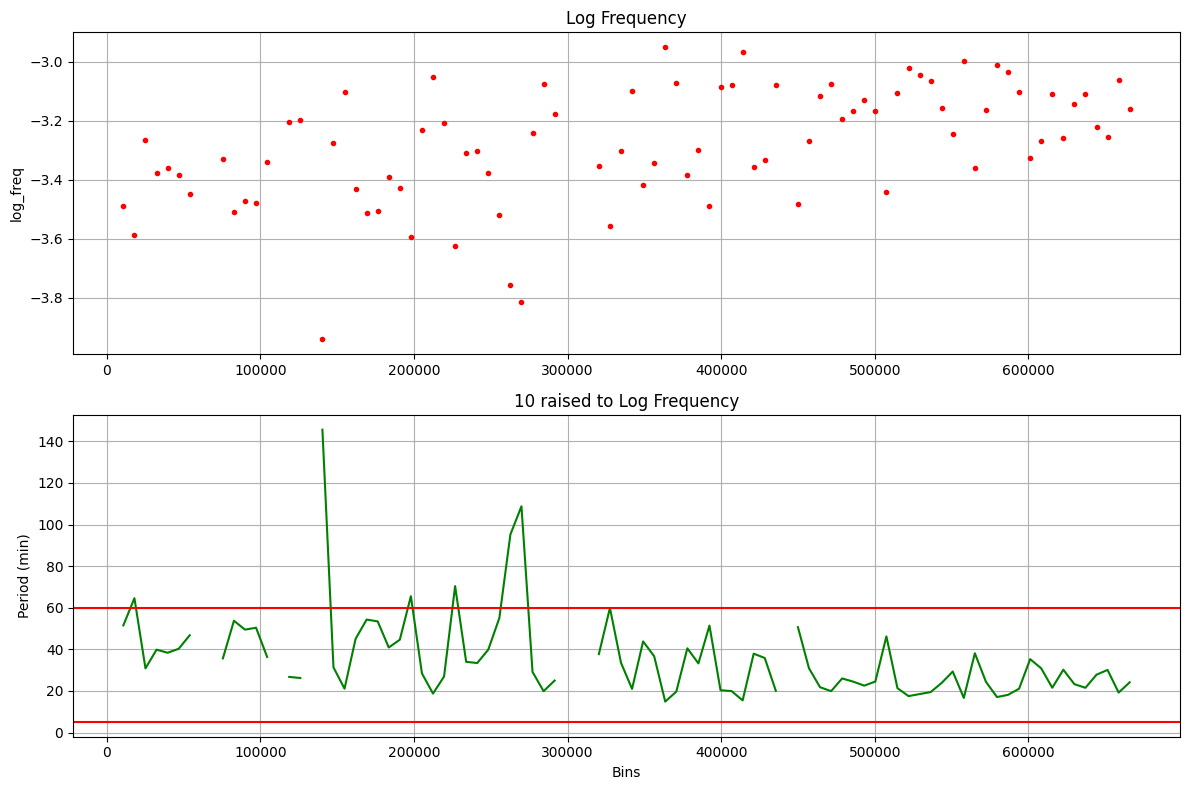

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(bins, log_freq_, 'r.')  
axs[0].set_title('Log Frequency')
axs[0].set_ylabel('log_freq')
axs[0].grid(True)

axs[1].plot(bins, (1/(10**np.array(log_freq_)))/60, 'g-')  
axs[1].set_title('10 raised to Log Frequency')
axs[1].set_ylabel('Period (min)')
axs[1].set_xlabel('Bins')
axs[1].grid(True)

plt.axhline(y=5, color='red', linestyle='-')
plt.axhline(y=60, color='red', linestyle='-')

plt.tight_layout()
plt.show()